## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from xgboost import XGBRegressor

## Set Random Seed and Load Data

In [2]:
# Set seed for reproducibility
np.random.seed(123)

# Import training and test data
trn = pd.read_csv('CW1_train.csv')
X_tst = pd.read_csv('CW1_test.csv')  # This does not include true outcomes

print(f"Training data shape: {trn.shape}")
print(f"Test data shape: {X_tst.shape}")

Training data shape: (10000, 31)
Test data shape: (1000, 30)


## Encode Categorical Variables

In [3]:
# Identify categorical columns
categorical_cols = ['cut', 'color', 'clarity']

# Label encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    trn[col] = le.fit_transform(trn[col])
    label_encoders[col] = le

# Apply same transformation to test set
for col in categorical_cols:
    X_tst[col] = label_encoders[col].transform(X_tst[col])

print(f"Training data after encoding: {trn.shape}")
print(f"Test data after encoding: {X_tst.shape}")

# # COMMENTED OUT: One-hot encoding alternative
# trn = pd.get_dummies(trn, columns=categorical_cols, drop_first=True)
# X_tst = pd.get_dummies(X_tst, columns=categorical_cols, drop_first=True)

Training data after encoding: (10000, 31)
Test data after encoding: (1000, 30)


# Dropping Features

In [4]:
# Calculate correlation between features and target
correlations = trn.corr()['outcome'].drop('outcome').abs().sort_values(ascending=False)

print("Feature correlations with target:")
print(correlations)

# Set correlation threshold
threshold = 0.05  # Remove features with correlation < 0.05

# Identify low-correlation features
low_corr_features = correlations[correlations < threshold].index.tolist()

print(f"\n{len(low_corr_features)} features with correlation < {threshold}:")
print(low_corr_features)

# Full feature set (no dropping)
X_full = trn.drop(columns=['outcome'])
y = trn['outcome']
X_tst_full = X_tst.copy()

# Remove low-correlation features from training
X = X_full.drop(columns=low_corr_features)

# Force test set to have identical columns/order (dropped-feature set)
X_tst = X_tst.reindex(columns=X.columns)

print(f"\nFeatures remaining: {X.shape[1]}")
print(f"Feature names: {X.columns.tolist()}")
print(f"Test set shape: {X_tst.shape}")

Feature correlations with target:
depth      0.411073
b3         0.225407
b1         0.173719
a1         0.149101
a4         0.122441
table      0.114977
cut        0.033081
z          0.031470
color      0.027024
x          0.020354
clarity    0.017822
price      0.016967
y          0.015924
a7         0.012512
b5         0.012370
b10        0.012036
b7         0.009241
a2         0.008760
a8         0.007983
b9         0.007324
a6         0.007238
a9         0.005361
b4         0.003845
a3         0.003126
b8         0.002645
carat      0.002538
a10        0.002492
b2         0.001640
a5         0.000690
b6         0.000079
Name: outcome, dtype: float64

24 features with correlation < 0.05:
['cut', 'z', 'color', 'x', 'clarity', 'price', 'y', 'a7', 'b5', 'b10', 'b7', 'a2', 'a8', 'b9', 'a6', 'a9', 'b4', 'a3', 'b8', 'carat', 'a10', 'b2', 'a5', 'b6']

Features remaining: 6
Feature names: ['depth', 'table', 'a1', 'a4', 'b1', 'b3']
Test set shape: (1000, 6)


## Split Data and Scale Features

In [5]:
# Split into train/validation (80/20) - X and y already defined above
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Full-feature split aligned to the same indices
X_full_train = X_full.loc[X_train.index]
X_full_val = X_full.loc[X_val.index]

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 8000
Validation set size: 2000


## Scale Features Using RobustScaler

In [6]:
# Use RobustScaler to handle outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_tst_scaled = scaler.transform(X_tst)

print("Data scaled using RobustScaler")

Data scaled using RobustScaler


In [7]:
# Initialize dictionaries to store scores
r2_scores = {}
mae_scores = {}

## Model A: Baseline Linear Regression

In [8]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions on validation set
yhat_lr = lr_model.predict(X_val_scaled)

# Evaluate performance
r2_lr = r2_score(y_val, yhat_lr)
mae_lr = mean_absolute_error(y_val, yhat_lr)
r2_scores["Linear Regression"] = r2_lr
mae_scores["Linear Regression"] = mae_lr
print(f"Local Validation R² (Linear Regression): {r2_lr:.4f}")
print(f"Mean Absolute Error (Linear Regression): {mae_lr:.4f}")

Local Validation R² (Linear Regression): 0.2870
Mean Absolute Error (Linear Regression): 8.4330


## Model B: Lasso Regression (L1 Regularization)

In [9]:
# Train Lasso Regression model with L1 penalty
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions on validation set
yhat_lasso = lasso_model.predict(X_val_scaled)

# Evaluate performance
r2_lasso = r2_score(y_val, yhat_lasso)
mae_lasso = mean_absolute_error(y_val, yhat_lasso)
r2_scores["Lasso Regression"] = r2_lasso
mae_scores["Lasso Regression"] = mae_lasso
print(f"Local Validation R² (Lasso Regression): {r2_lasso:.4f}")
print(f"Mean Absolute Error (Lasso Regression): {mae_lasso:.4f}")

Local Validation R² (Lasso Regression): 0.2851
Mean Absolute Error (Lasso Regression): 8.4357


## Feature Selection via Lasso

In [10]:
# Create a series to see which coefficients were set to zero
coef_series = pd.Series(lasso_model.coef_, index=X.columns)
dropped_features = coef_series[coef_series == 0]

print(f"\nFeatures with non-zero coefficients: {len(coef_series) - len(dropped_features)}")
print(f"Features Lasso set to zero: {len(dropped_features)}")

if len(dropped_features) > 0:
    print("\nFeatures removed by Lasso:")
    print(dropped_features.index.tolist())


Features with non-zero coefficients: 6
Features Lasso set to zero: 0


## Model C: Ridge Regression (L2 Regularization)

In [11]:
# Train Ridge Regression model with L2 penalty
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on validation set
yhat_ridge = ridge_model.predict(X_val_scaled)

# Evaluate performance
r2_ridge = r2_score(y_val, yhat_ridge)
mae_ridge = mean_absolute_error(y_val, yhat_ridge)
r2_scores["Ridge Regression"] = r2_ridge
mae_scores["Ridge Regression"] = mae_ridge
print(f"Local Validation R² (Ridge Regression): {r2_ridge:.4f}")
print(f"Mean Absolute Error (Ridge Regression): {mae_ridge:.4f}")

Local Validation R² (Ridge Regression): 0.2870
Mean Absolute Error (Ridge Regression): 8.4330


# Model D: Random Forest Regressor

In [12]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123, n_jobs=-1, min_samples_leaf=10)
rf_model.fit(X_full_train, y_train)

# Make predictions on validation set
yhat_rf = rf_model.predict(X_full_val)

# Evaluate performance
r2_rf = r2_score(y_val, yhat_rf)
mae_rf = mean_absolute_error(y_val, yhat_rf)
r2_scores["Random Forest"] = r2_rf
mae_scores["Random Forest"] = mae_rf
print(f"Local Validation R² (Random Forest): {r2_rf:.4f}")
print(f"Mean Absolute Error (Random Forest): {mae_rf:.4f}")

Local Validation R² (Random Forest): 0.4448
Mean Absolute Error (Random Forest): 7.4219


# Model E: XGBoost Regressor

In [13]:
# Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=123,
    n_jobs=-1,
    early_stopping_rounds=10
)

xgb_model.fit(
    X_full_train,
    y_train,
    eval_set=[(X_full_val, y_val)],
    verbose=False
)

# Make predictions on validation set
yhat_xgb = xgb_model.predict(X_full_val)

# Evaluate performance
r2_xgb = r2_score(y_val, yhat_xgb)
mae_xgb = mean_absolute_error(y_val, yhat_xgb)
r2_scores["XGBoost"] = r2_xgb
mae_scores["XGBoost"] = mae_xgb
print(f"Local Validation R² (XGBoost): {r2_xgb:.4f}")
print(f"Mean Absolute Error (XGBoost): {mae_xgb:.4f}")

Local Validation R² (XGBoost): 0.4663
Mean Absolute Error (XGBoost): 7.3365


# Model F: Neural Network (MLPRegressor)

In [14]:
# Import MLPRegressor
from sklearn.neural_network import MLPRegressor

# Train MLP Regressor with hidden layer specification
mlp_model = MLPRegressor(
    hidden_layer_sizes=(5, 5, 5),
    activation='relu',
    solver='adam',
    learning_rate_init=0.003,
    alpha=0.01,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=100,
    random_state=123
)

mlp_model.fit(X_train_scaled, y_train)

# Make predictions on validation set
yhat_mlp = mlp_model.predict(X_val_scaled)

# Evaluate performance
r2_mlp = r2_score(y_val, yhat_mlp)
mae_mlp = mean_absolute_error(y_val, yhat_mlp)

# Add to scores
r2_scores["MLP"] = r2_mlp
mae_scores["MLP"] = mae_mlp

print(f"Local Validation R² (MLP): {r2_mlp:.4f}")
print(f"Mean Absolute Error (MLP): {mae_mlp:.4f}")

Local Validation R² (MLP): 0.4633
Mean Absolute Error (MLP): 7.3089


# Model G: Keras

In [15]:
import tensorflow as tf
from keras import layers, regularizers

model = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mae'])

lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    patience=10, factor=0.5, min_lr=1e-5, verbose=1
)
es_cb = tf.keras.callbacks.EarlyStopping(
    patience=100, restore_best_weights=True, verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=64,
    verbose=1,
    callbacks=[lr_cb, es_cb]
)

model.evaluate(X_val_scaled, y_val, verbose=0)

Epoch 1/300
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 132.8350 - mae: 9.2613 - val_loss: 153.7699 - val_mae: 9.9697 - learning_rate: 0.0010
Epoch 2/300
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 108.8012 - mae: 8.3561 - val_loss: 122.3422 - val_mae: 8.7943 - learning_rate: 0.0010
Epoch 3/300
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100.7915 - mae: 8.0001 - val_loss: 102.8742 - val_mae: 8.0089 - learning_rate: 0.0010
Epoch 4/300
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.6957 - mae: 7.8962 - val_loss: 95.6589 - val_mae: 7.7328 - learning_rate: 0.0010
Epoch 5/300
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98.0044 - mae: 7.8765 - val_loss: 93.2714 - val_mae: 7.6212 - learning_rate: 0.0010
Epoch 6/300
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.6777 - mae: 7.7995 - val_loss: 92.3200 - val_mae: 7.5786 - learning_rate: 0.0010
Epoch 7/300
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96.0676 - mae: 7.7902 - val_loss: 91.5697 - val_mae: 7.5564 - l

[88.46434783935547, 7.418154716491699]

In [16]:

yhat_keras = model.predict(X_val_scaled).ravel()
r2_keras = r2_score(y_val, yhat_keras)
mae_keras = mean_absolute_error(y_val, yhat_keras)

r2_scores["Keras"] = r2_keras
mae_scores["Keras"] = mae_keras

print(f"Keras Validation R²: {r2_keras:.4f}")
print(f"Keras Validation MAE: {mae_keras:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Keras Validation R²: 0.4474
Keras Validation MAE: 7.4182


# Test Set Accuracy

In [17]:
# Calculate training accuracy for all models
train_r2_scores = {}
train_mae_scores = {}

# Linear Regression
yhat_lr_train = lr_model.predict(X_train_scaled)
train_r2_scores["Linear Regression"] = r2_score(y_train, yhat_lr_train)
train_mae_scores["Linear Regression"] = mean_absolute_error(y_train, yhat_lr_train)

# Lasso Regression
yhat_lasso_train = lasso_model.predict(X_train_scaled)
train_r2_scores["Lasso Regression"] = r2_score(y_train, yhat_lasso_train)
train_mae_scores["Lasso Regression"] = mean_absolute_error(y_train, yhat_lasso_train)

# Ridge Regression
yhat_ridge_train = ridge_model.predict(X_train_scaled)
train_r2_scores["Ridge Regression"] = r2_score(y_train, yhat_ridge_train)
train_mae_scores["Ridge Regression"] = mean_absolute_error(y_train, yhat_ridge_train)

# Random Forest (full features)
yhat_rf_train = rf_model.predict(X_full_train)
train_r2_scores["Random Forest"] = r2_score(y_train, yhat_rf_train)
train_mae_scores["Random Forest"] = mean_absolute_error(y_train, yhat_rf_train)

# XGBoost (full features)
yhat_xgb_train = xgb_model.predict(X_full_train)
train_r2_scores["XGBoost"] = r2_score(y_train, yhat_xgb_train)
train_mae_scores["XGBoost"] = mean_absolute_error(y_train, yhat_xgb_train)

# MLP
yhat_mlp_train = mlp_model.predict(X_train_scaled)
train_r2_scores["MLP"] = r2_score(y_train, yhat_mlp_train)
train_mae_scores["MLP"] = mean_absolute_error(y_train, yhat_mlp_train)

# Keras
yhat_keras_train = model.predict(X_train_scaled).ravel()
train_r2_scores["Keras"] = r2_score(y_train, yhat_keras_train)
train_mae_scores["Keras"] = mean_absolute_error(y_train, yhat_keras_train)

# Print training accuracy
print("="*60)
print("Model Comparison")
print("="*60)
for model_name in train_r2_scores.keys():
    train_r2 = train_r2_scores[model_name]
    train_mae = train_mae_scores[model_name]
    val_r2 = r2_scores[model_name]
    val_mae = mae_scores[model_name]
    print(f"{model_name:20s} | Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f} | Δ: {train_r2-val_r2:.4f}")
    
best_model_name = max(r2_scores, key=r2_scores.get)
best_r2 = r2_scores[best_model_name]

print("="*60)
print(f"Best model: {best_model_name} (R² = {best_r2:.4f})")
print("="*60)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
Model Comparison
Linear Regression    | Train R²: 0.2880 | Val R²: 0.2870 | Δ: 0.0010
Lasso Regression     | Train R²: 0.2870 | Val R²: 0.2851 | Δ: 0.0019
Ridge Regression     | Train R²: 0.2880 | Val R²: 0.2870 | Δ: 0.0010
Random Forest        | Train R²: 0.4861 | Val R²: 0.4448 | Δ: 0.0413
XGBoost              | Train R²: 0.5799 | Val R²: 0.4663 | Δ: 0.1136
MLP                  | Train R²: 0.4750 | Val R²: 0.4633 | Δ: 0.0116
Keras                | Train R²: 0.4846 | Val R²: 0.4474 | Δ: 0.0372
Best model: XGBoost (R² = 0.4663)


## MAE Comparison Plot

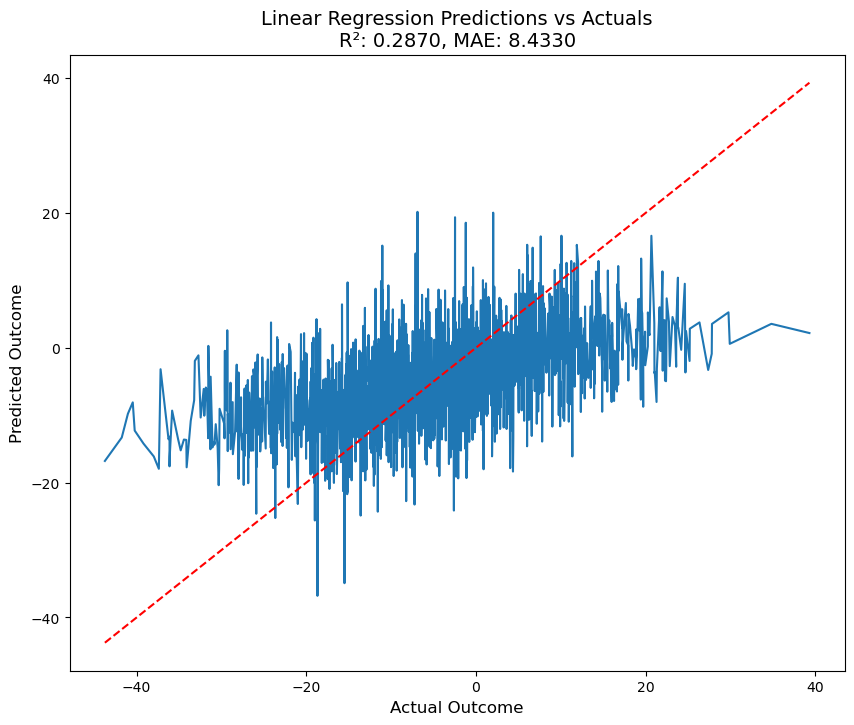

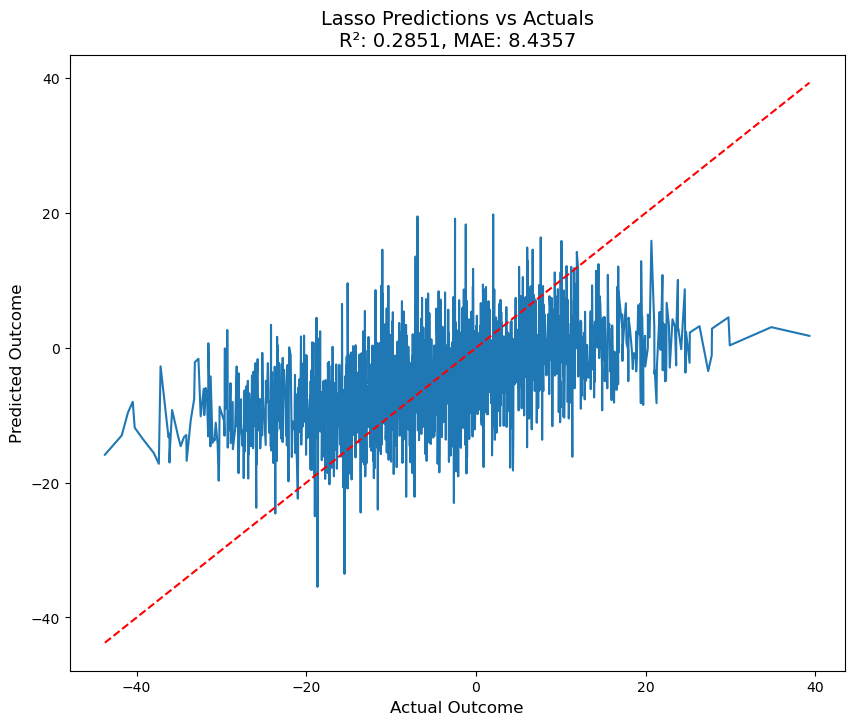

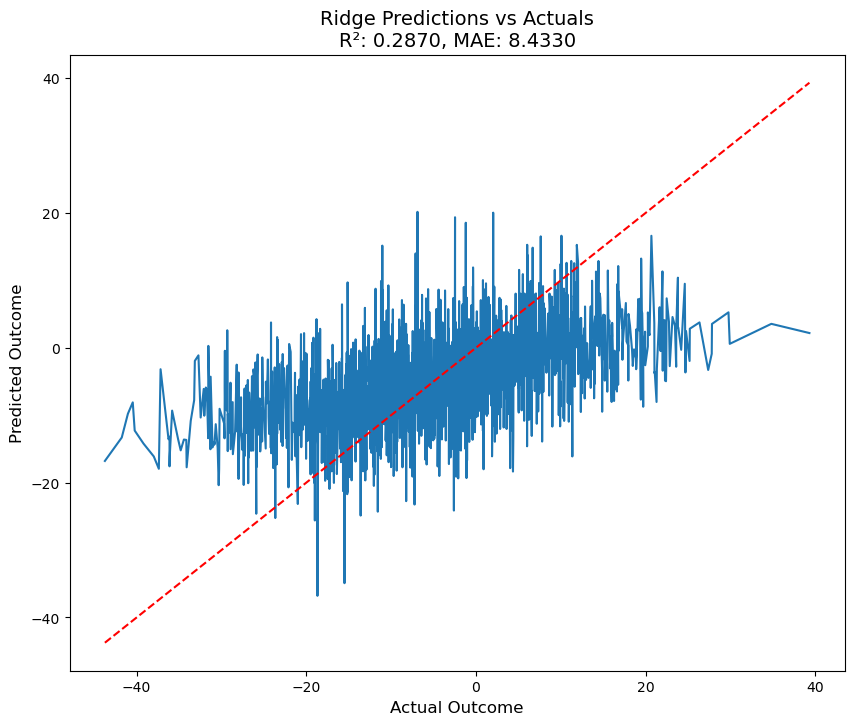

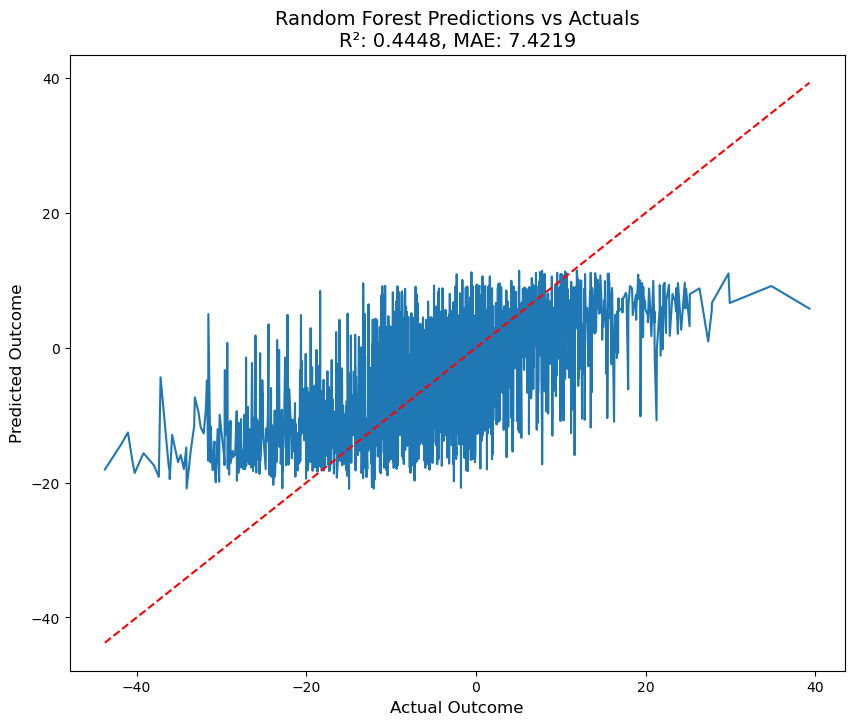

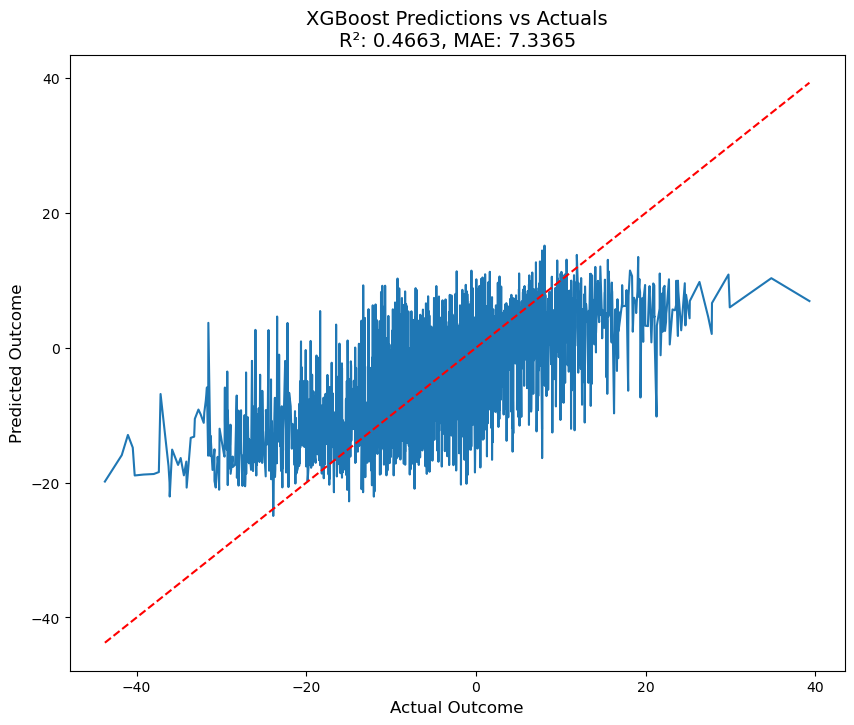

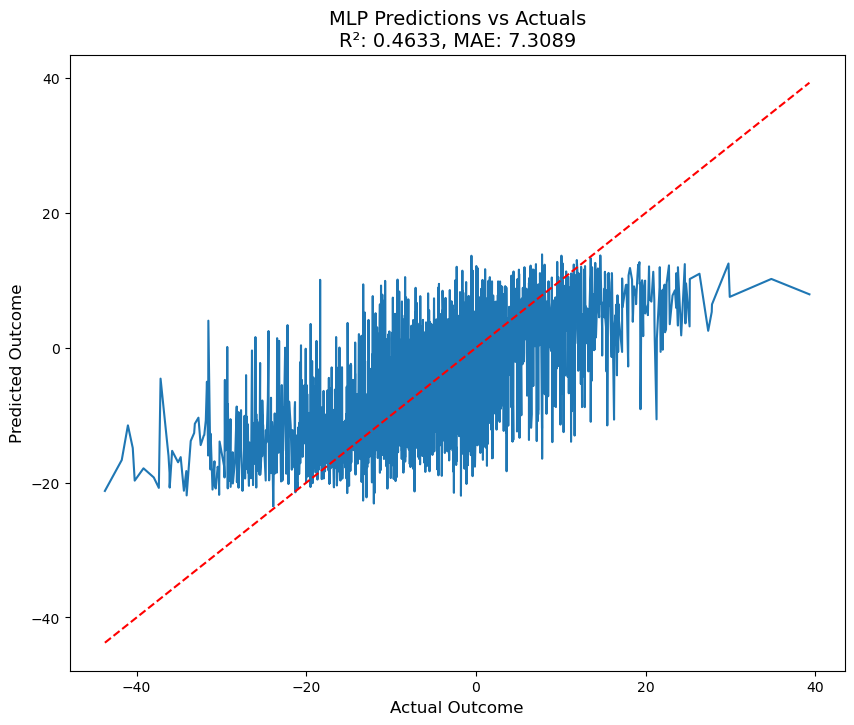

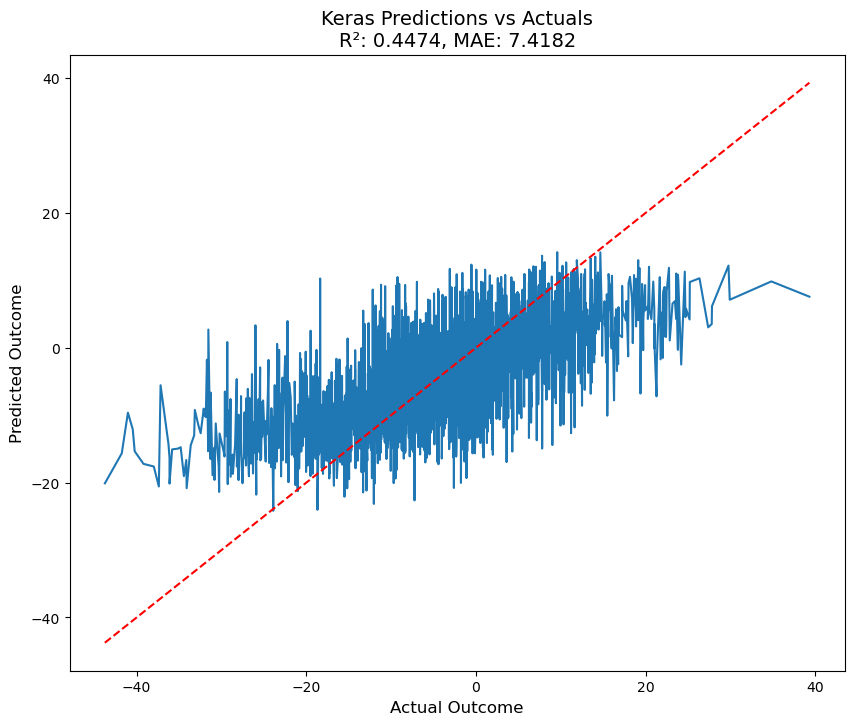

In [18]:
models_data = [
    ('Linear Regression', yhat_lr, r2_lr, mae_lr),
    ('Lasso', yhat_lasso, r2_lasso, mae_lasso),
    ('Ridge', yhat_ridge, r2_ridge, mae_ridge),
    ('Random Forest', yhat_rf, r2_rf, mae_rf),
    ('XGBoost', yhat_xgb, r2_xgb, mae_xgb),
    ('MLP', yhat_mlp, r2_mlp, mae_mlp),
    ('Keras', yhat_keras, r2_keras, mae_keras)
]

for model_name, predictions, r2, mae in models_data:
    plt.figure(figsize=(10, 8))
    
    sorted_idx = np.argsort(y_val.values)
    sorted_actual = y_val.values[sorted_idx]
    sorted_predicted = predictions[sorted_idx]
    
    plt.plot(sorted_actual, sorted_predicted)
    plt.title(f'{model_name} Predictions vs Actuals\nR²: {r2:.4f}, MAE: {mae:.4f}', fontsize=14)
    
    #perfect line
    plt.plot(sorted_actual, sorted_actual, color='red', linestyle='--', label='Perfect Prediction')
    
    plt.xlabel('Actual Outcome', fontsize=12)
    plt.ylabel('Predicted Outcome', fontsize=12)
 
    plt.show()

## MLP Hyperparameter Tuning (Optional)

In [19]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for MLP (narrower, focused on smaller models)
param_grid_mlp = {
    'hidden_layer_sizes': [(10, 10), (15, 10), (20, 15), (25, 15)],
    'alpha': [0.001, 0.01, 0.05],
    'learning_rate_init': [0.001, 0.003, 0.01],
    'max_iter': [1000]
}

# Create base MLP model
mlp_base = MLPRegressor(
    activation='relu',
    solver='adam',
    random_state=123,
    early_stopping=True,
    n_iter_no_change=50
)

# Grid search
print("Starting MLP GridSearchCV... (this may take a few minutes)")
grid_search_mlp = GridSearchCV(
    mlp_base,
    param_grid_mlp,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp.fit(X_train_scaled, y_train)

print(f"\nBest MLP parameters: {grid_search_mlp.best_params_}")
print(f"Best CV R² score: {grid_search_mlp.best_score_:.4f}")

# Evaluate best model on validation set
best_mlp = grid_search_mlp.best_estimator_
yhat_mlp_tuned = best_mlp.predict(X_val_scaled)
r2_mlp_tuned = r2_score(y_val, yhat_mlp_tuned)
mae_mlp_tuned = mean_absolute_error(y_val, yhat_mlp_tuned)

print(f"Tuned MLP Validation R²: {r2_mlp_tuned:.4f}")
print(f"Tuned MLP Validation MAE: {mae_mlp_tuned:.4f}")
print(f"Original MLP Validation R²: {r2_mlp:.4f}")

Starting MLP GridSearchCV... (this may take a few minutes)
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best MLP parameters: {'alpha': 0.05, 'hidden_layer_sizes': (25, 15), 'learning_rate_init': 0.001, 'max_iter': 1000}
Best CV R² score: 0.4624
Tuned MLP Validation R²: 0.4568
Tuned MLP Validation MAE: 7.3249
Original MLP Validation R²: 0.4633


## Test Set Predictions (Uncomment to use)

In [20]:
# Make predictions on test set
yhat_test = mlp_model.predict(X_tst_scaled)

# Format submission
out = pd.DataFrame({'yhat': yhat_test})
out.to_csv('CW1_submission_K23067889.csv', index=False)  # Use your k-number here